# Arbeidsløype for grafkonversjon med Grew

1. Last inn en NDT-formatert trebank og [konverter ordklasser og morfologiske trekk](#konverter-ordklasser-og-morfologiske-trekk) til UD-POS-tags og feats
2. [Legg til "SpaceAfter=No"](#legg-til-spaceafterno) i `MISC`-feltet for tegnsetting som ikke skal ha mellomrom.
3. [Last inn eksisterende regler](#last-inn-eksisterende-regler) i et GRS-objekt og kjør det på korpuset
4. [Søk etter et setningsmønster som må endres i trebanken](#søk-etter-setningsmønster-i-trebanken)
5. [Skriv en konverteringsregel med mønsteret](#2-skriv-en-konverteringsregel-med-mønsteret)
6. Hvis flere mønstre/regler kreves for å konvertere riktig, velg en strategi som gir én riktig graf per setning (vanligvis `Onf`)
7. Visualiser en setningsgraf

In [1]:
# Fix PATH to include OPAM binaries where grewpy_backend is located
import os

os.environ["PATH"] = os.environ["HOME"] + "/.opam/5.2.0/bin:" + os.environ["PATH"]

# Check if a norwegian spacy model exists in the virtual environment
try:
    import nb_core_news_md
except ModuleNotFoundError:
    print("Download a Norwegian spacy model to visualise graphs with Displacy")
    !python -m spacy download nb_core_news_md

In [2]:
import grewpy
from grewpy import Corpus, CorpusDraft, Request

grewpy.set_config("ud")  # ud or basic

connected to port: 33073


## Konverter ordklasser og morfologiske trekk

In [3]:
from pathlib import Path

from ndt2ud.morphological_features import convert_morphology
from ndt2ud.parse_conllu import parse_conll_file
from ndt2ud.utils import write_conll

treebank_file = (
    "../spoken_norwegian_resources/treebanks/Norwegian-NynorskLIA/aal_uio_06.conll"
)
UD_treebank_file = "../UD_output.conllu"

# Load the NDT treebank and convert the part of speech and morphological features to UD features
conllu_data = parse_conll_file(Path(treebank_file))
morphdata = convert_morphology(conllu_data)
write_conll(morphdata, UD_treebank_file, drop_comments=False)

## Legg til "SpaceAfter=No"

> **OBS** Dette steget har ingen effekt på LIA-trebanken, siden setningsavsluttende tegnsetting har et mellomrom foran seg.
Se annotasjonsretningslinjene  for LIA [her](https://tekstlab.uio.no/LIA/pdf/parseretningslinjer-lia12042019.pdf).

In [4]:
from ndt2ud.utils import udapi_fixes

udapi_fixes(UD_treebank_file, UD_treebank_file)

## Last inn korpuset med Grewpy

Se [Grewpy-dokumentasjonen](https://grew.fr/python/grewpy.html#grewpy-package) for mer info om APIet i python. 

In [126]:
from pprint import pprint

from grewpy import Corpus

corpusLIA = Corpus(UD_treebank_file)

print(
    "Antall setninger i trebanken: ", corpusLIA.count(Request())
)  # Empty request will match all sentences

print("Statistikk over ulike morfologiske trekk i trebanken:")
pprint(
    corpusLIA.count_feature_values(exclude=["form", "lemma", "textform", "wordform"])
)

Antall setninger i trebanken:  84
Statistikk over ulike morfologiske trekk i trebanken:
{'Animacy': {'Hum': 117},
 'Case': {'Acc': 29, 'Nom': 114},
 'Definite': {'Ind': 138},
 'Degree': {'Cmp': 1, 'Pos': 58, 'Sup': 1},
 'Gender': {'Fem': 96, 'Masc': 108, 'Neut': 148},
 'Mood': {'Ind': 210},
 'NumType': {'Card': 22},
 'Number': {'Plur': 212},
 'Person': {'1': 70, '2': 16, '3': 121},
 'Polarity': {'Neg': 15},
 'Poss': {'Yes': 4},
 'PronType': {'Art': 25,
              'Dem': 31,
              'Ind': 8,
              'Int': 2,
              'Prs': 215,
              'Prs,Tot': 1,
              'Tot': 3},
 'Reflex': {'Yes': 3},
 'Tense': {'Past': 179, 'Pres': 31},
 'VerbForm': {'Fin': 210, 'Inf': 50, 'Part': 10},
 '__RAW_MISC__': {'hov': 965, 'inf': 48, 'led': 416},
 'upos': {'ADJ': 65,
          'ADP': 145,
          'ADV': 116,
          'AUX': 93,
          'CCONJ': 100,
          'DET': 64,
          'INTJ': 15,
          'NOUN': 194,
          'NUM': 22,
          'PART': 25,
        

### Kjør eksisterende omskrivingsregler på trebanken

In [127]:
from grewpy import GRS

grew_rules_file = "../rules/NDT_to_UD.grs"
NDT_to_UD_grs = GRS(grew_rules_file)

# Bruk reglene for nynorsk på LIA : main_nn
corpus = NDT_to_UD_grs.apply(Corpus(corpusLIA.to_conll()), strat="main_nn")

### Sammenlign trebanken før og etter omskrivingsreglene

In [128]:
pprint(corpusLIA.edge_diff(corpus))

{'common': np.int64(164),
 'f_measure': np.float64(0.115),
 'left': np.int64(1265),
 'precision': np.float64(0.115),
 'recall': np.float64(0.115),
 'right': np.int64(1265)}


In [52]:
pprint(corpus.count_feature_values(exclude=["form", "lemma", "textform", "wordform"]))

{'Animacy': {'Hum': 117},
 'Case': {'Acc': 29, 'Nom': 114},
 'Definite': {'Ind': 138},
 'Degree': {'Cmp': 1, 'Pos': 58, 'Sup': 1},
 'Gender': {'Fem': 96, 'Masc': 108, 'Neut': 148},
 'Mood': {'Ind': 210},
 'NumType': {'Card': 22},
 'Number': {'Plur': 212},
 'Person': {'1': 70, '2': 16, '3': 121},
 'Polarity': {'Neg': 15},
 'Poss': {'Yes': 4},
 'PronType': {'Art': 46,
              'Dem': 10,
              'Ind': 8,
              'Int': 2,
              'Prs': 215,
              'Prs,Tot': 1,
              'Tot': 3},
 'Reflex': {'Yes': 3},
 'Tense': {'Past': 179, 'Pres': 31},
 'VerbForm': {'Fin': 210, 'Inf': 50, 'Part': 10},
 '__RAW_MISC__': {'hov': 965, 'inf': 48, 'led': 416},
 'upos': {'ADJ': 65,
          'ADP': 113,
          'ADV': 148,
          'AUX': 93,
          'CCONJ': 100,
          'DET': 64,
          'INTJ': 15,
          'NOUN': 194,
          'NUM': 22,
          'PART': 25,
          'PRON': 223,
          'PROPN': 5,
          'PUNCT': 11,
          'SCONJ': 50,
     

## Skriv nye regler


### Steg 1: Søk etter setningsmønster i trebanken

Se retningslinjene for NDT-trebanken som definerer hvilke trekk og relasjoner vi evt. må endre. 

- Se Grew-dokumentasjonen for info om [`Request`](https://grew.fr/doc/request/) og syntaks for mønstrene (`pattern`-feltet i Request-objektet).

- Mønstersøk i eksisterende UD-versjon kan også gjøres i Grew Match: https://universal.grew.fr/?corpus=UD_Norwegian-Bokmaal@2.16

- Regelutikling kan også gjøres i Arborator, hvor vi har et privat prosjekt: [NDT_conversion_to_UD](https://arboratorgrew.elizia.net/#/projects/NDT_conversion_to_UD)



### Eksempel: ukjent POS-tag "nol" 

- Fra retningslinjene til [LIA](https://tekstlab.uio.no/LIA/pdf/parseretningslinjer-lia12042019.pdf): 

> #### 5.2 Discourse fillers
> Nølelyder som e og m (discourse filler i Dobrovolje & Nivre) gir vi ordklassetaggen nol og funksjonen
FYLL. Nølelydene behandler vi likt som pausetegnet og er, dermed, dependent til ordet som kommer 
til høyre i setningsstrengen.




In [53]:
from grewpy import Request

# Definer setningsmønsteret
pattern = "N [upos=nol]; e: H -> N; "
request = Request().pattern(pattern)
occurrences = corpus.search(request)

print(f"Antall treff: {corpus.count(request)}")  # type: ignore

print("Setninger som matcher mønsteret: ")

for occ in occurrences:
    sent_id = occ["sent_id"]
    pattern_match = occ["matching"]
    graph = corpus.get(sent_id)
    text = graph.to_sentence()
    N_node_id = pattern_match["nodes"]["N"]
    H_node_id = pattern_match["nodes"]["H"]

    print()
    print(f"{sent_id=}")
    print(f"{text=}")  # type: ignore
    print(f"{pattern_match=}")
    print(f"Node N: {graph[N_node_id]}")
    print(f"Node H: {graph[H_node_id]}")
    print(f"Edge: {graph.edge(H_node_id, N_node_id)}")

Antall treff: 7
Setninger som matcher mønsteret: 

sent_id='82'
text='den same sommaren så vart det ihelrive ein e tolv femten sauer # nedi Storberghovda ei natt '
pattern_match={'nodes': {'N': '9', 'H': '10'}, 'edges': {'e': {'source': '10', 'label': 'FYLL', 'target': '9'}}}
Node N: {'__RAW_MISC__': 'hov', 'form': 'e', 'lemma': 'e', 'textform': 'e', 'upos': 'nol', 'wordform': 'e'}
Node H: {'NumType': 'Card', 'Number': 'Plur', '__RAW_MISC__': 'hov', 'form': 'tolv', 'lemma': 'tolv', 'textform': 'tolv', 'upos': 'NUM', 'wordform': 'tolv'}
Edge: {'1': 'FYLL'}

sent_id='79'
text='og resten av sommaren så måtte vi da ha han i sokn # i på vollane og # e til å passe på han til han hadde lagt seg '
pattern_match={'nodes': {'N': '19', 'H': '22'}, 'edges': {'e': {'source': '22', 'label': 'FYLL', 'target': '19'}}}
Node N: {'__RAW_MISC__': 'hov', 'form': 'e', 'lemma': 'e', 'textform': 'e', 'upos': 'nol', 'wordform': 'e'}
Node H: {'VerbForm': 'Inf', '__RAW_MISC__': 'inf', 'form': 'passe', 'lemma': '

### Steg 2: Skriv en konverteringsregel

In [129]:
from grewpy import CorpusDraft

# Gjør om corpus til et draft (fordi grewpy.Corpus er immutable, mens CorpusDraft er mutable)
draft = CorpusDraft(corpus)

#### Alternativ 1: 
Gå gjennom søketreffene og endre grafen i draft-korpuset

In [36]:
for occ in occurrences:
    sent_id = occ["sent_id"]
    # Hent ut variabler for nodene og kantene vi traff med Request-søket
    N_node_id = occ["matching"]["nodes"]["N"]
    H_node_id = occ["matching"]["nodes"]["H"]
    e_edge = occ["matching"]["edges"]["e"]

    # Hent ut grafen til setningen vi traff
    draft[sent_id][N_node_id]["upos"] = "INTJ"
    draft[sent_id].edge(H_node_id, N_node_id).update({"1": "discourse", "2": "filler"})

# Gjør om resulterende draft til et `Corpus` før vi bruker `count`-metoden
corpus2 = Corpus(draft)

#### Alternativ 2: 

Skriv en python-funksjon som mappes til alle grafene, og som tar en graf som input. 
Søkemønsteret som filtrerer grafene må skrives om til python. 

In [61]:
def relabel_nol(graph):
    for node in graph:
        if "upos" in graph[node] and graph[node]["upos"] == "nol":
            graph[node]["upos"] = "INTJ"
    return graph


draft.map(relabel_nol, in_place=True)
# Gjør om resulterende draft til et `Corpus` før vi bruker `count`-metoden
corpus2 = Corpus(draft)

#### Alternativ 3: 
Skriv en regel med Grew sin Graph Rewriting System-syntaks og kjør den rett på `Corpus`-objektet

In [ ]:
from grewpy import GRSDraft

grew_strategy = """
strat main {
    Onf (relabel_nol_discourse_deprel)
}

rule relabel_nol_discourse_deprel { 
    pattern {
        X [ upos=nol ];
        e: Y -[FYLL]-> X; 
    }
    commands {
        X.upos=INTJ;
        e.1=discourse;
        e.2=filler;
    } 
}
"""

# Last inn regelen som et graph rewriting system
grs_draft = GRSDraft(grew_strategy)
grs = GRS(grs_draft)
corpus2 = grs.apply(Corpus(draft))

{'common': np.int64(1422),
 'left': np.int64(7),
 'right': np.int64(7),
 'precision': np.float64(0.995),
 'recall': np.float64(0.995),
 'f_measure': np.float64(0.995)}

#### Sammenlign søketreff

In [74]:
print(
    "Treff på samme mønster som i regelen:", corpus2.count(request)
)  # Burde være 0 nå
print(
    "Treff på endringen som ble gjort: ",
    corpus2.count(Request("pattern { N[upos=INTJ]; H -[1=discourse, 2=filler]-> N;}")),
)

# Sammenlign corpus før og etter regelen
corpus2.edge_diff(corpus)

Treff på samme mønster som i regelen: 0
Treff på endringen som ble gjort:  7


{'common': np.int64(1422),
 'left': np.int64(7),
 'right': np.int64(7),
 'precision': np.float64(0.995),
 'recall': np.float64(0.995),
 'f_measure': np.float64(0.995)}

## Visualiser setningsgrafer

/home/ingeridd/prosjekter/grew_ndt2ud/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sentence ID: 8
Text: ja det var det eg hugsa på e Reine der var det imellom sytti og åtti mjølkekyr # og ein del kviger og og kalvar 
Using alternative visualization method with dot and graphviz


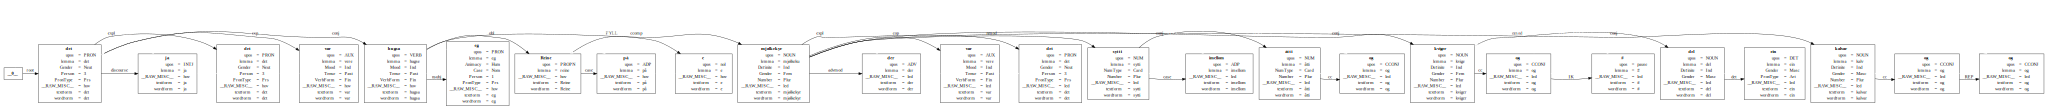

In [ ]:
from grewpy.network import GrewError
from IPython.display import HTML, SVG, display
from spacy import displacy
from spacy_conll import init_parser
from spacy_conll.parser import ConllParser

from ndt2ud.visualize import visualize_graph_displacy, visualize_graph_dot


def visualize_graph(graph):
    sent_id = graph.meta["sent_id"]
    print(f"Sentence ID: {sent_id}")
    print(f"Text: {graph.to_sentence()}")
    output_name = f"graph_{sent_id}"
    try:
        # graph.to_svg() has a known issue with some grewpy installations, but may work in some environments
        svg_result = graph.to_svg()
        Path(f"{output_name}.svg").open("w", encoding="utf-8").write(svg_result)
        visual_graph = SVG(svg_result)
    except GrewError as e:
        conllstr = graph.to_conll()

        if "nlp" not in locals():
            nlp = ConllParser(init_parser("nb_core_news_md", "spacy"))
        try:
            doc = nlp.parse_conll_text_as_spacy(conllstr)  # type:ignore
            visual_graph = HTML(
                displacy.render(
                    doc,
                    style="dep",
                    jupyter=False,
                    options={"compact": False, "color": "green", "distance": 100.0},
                )
            )
            # visual_graph = HTML(visualize_graph_displacy(graph, nlp, output_name=output_name))

        except ValueError:
            print(f"Using alternative visualization method with dot and graphviz")
            result = visualize_graph_dot(graph, output_name)
            visual_graph = SVG(filename=result)

    display(visual_graph)


# Hent ut en bestemt setningsgraf med setnings-ID
sent_id = "8"  # '82', '79', '73', '47', '42', '8', '4'
visualize_graph(corpus[sent_id])

Sentence ID: 8
Text: ja det var det eg hugsa på e Reine der var det imellom sytti og åtti mjølkekyr # og ein del kviger og og kalvar 
Using alternative visualization method with dot and graphviz


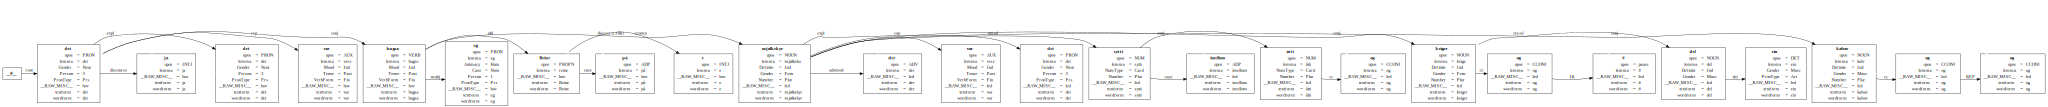

In [ ]:
# Se på samme grafen etter omskrivingsregelen
visualize_graph(corpus2[sent_id])

## Lagre regler i filer 

Lagre reglene i GREW-format i en `grs`-fil, med valgt strategi. 


In [ ]:
grs_draft.save("../rules/extra_LIA_fixes.grs")


# full_grs_draft = GRSDraft(NDT_to_UD_grs.json()["filename"])
# full_grs_draft.save("../rules/convert_NDT2UD.grs")